# DTM (Figures 1, 2 and Tables 1, 2)

This is adapted (partially) from https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/dtm_example.ipynb


In [1]:
from gensim import corpora, utils
from gensim.models.wrappers.dtmmodel import DtmModel
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
import json
import re

from gensim.parsing.preprocessing import STOPWORDS

# script author (me) defined stop words
STOPWORDS_ = ['rt', '-', '', 'httpst', 'amp']

# load the tweets
documents = []
time_seq = []
weeknum = ''
with open('../data/c_twitter.json') as f_in:
    for i, l in enumerate(f_in):
        c_twt = json.loads(l)
        
        # remove punctuation and stopwords for this analysis
        c_twt['c_text'] = re.sub('[\.,#?!]', '', c_twt['c_text'])
        words = c_twt['c_text'].split()
        words = [w for w in words if (w not in STOPWORDS and w not in STOPWORDS_)]
        words = [bytes(w, 'utf-8') for w in words]
        
        # c_twt: {'weeknum': str, 'c_text': str, 'tags': [str]}
        documents.append(words)
        
        if weeknum != c_twt['weeknum']:
            time_seq.append(i)
            weeknum = c_twt['weeknum']
            
time_seq = time_seq[1:]
time_seq.append(len(documents))

acc = 0
for i in range(1, len(time_seq)):
    acc = acc + time_seq[i-1]
    time_seq[i] = time_seq[i] - acc

print(time_seq)

[70347, 35960, 96046, 122011, 24353, 8886, 22804, 96051, 48342, 22970, 18543, 75741, 44883]


In [3]:
class DTMcorpus(corpora.textcorpus.TextCorpus):

    def get_texts(self):
        return self.input

    def __len__(self):
        return len(self.input)

corpus = DTMcorpus(documents)

In [4]:
dtm_binary_path = '/high_spd_work/sm_w2v/tools/dtm/dtm/dtm'
model = DtmModel(dtm_binary_path, corpus, time_seq, num_topics=10,
                 id2word=corpus.dictionary, initialize_lda=True, rng_seed=0)

In [5]:
topics = model.show_topic(topicid=3, time=11, topn=20)
topics

[(0.050156501504618353, 'prep'),
 (0.044636961007591916, 'test'),
 (0.041063859295526847, 'win'),
 (0.038732046600447635, 'symptoms'),
 (0.03776415054135665, '13'),
 (0.036730133791640418, 'read'),
 (0.033224673200269998, 'set'),
 (0.02557694694335946, 'hiv'),
 (0.023975168367560386, 'life'),
 (0.023503584635408983, 'competition'),
 (0.021241619018683777, 'dont'),
 (0.020306622926553254, 'boards'),
 (0.01999541412821234, 'giveaway'),
 (0.019689847320453049, 'justmustard'),
 (0.018937299657844946, 'pancakeday'),
 (0.018836109233961888, 'rtampf'),
 (0.01455591116756412, 'immediately'),
 (0.014315698193533323, 'joke'),
 (0.013249766373915976, '100'),
 (0.012383662842504591, 'week')]

# Figure 1, 2 and Table 1, 2: Dynamic Topic Modeling

I'm proposing that in figures 1 and 2, we pick 2 topics from the Dynamic Topic Model, and describe the progression in time of these 2 topics with time series graphs, and tables 1 and 2 will be top 10 tables of these same topics over time


Topic ID's 8, 7 and 3 are all interesting

In [6]:
# This cell just gets the week nums (YYYY-WW)
def weeknums():
    # first  week is 2015-47
    week = 47
    year = 2015
    weeknums = []
    for i in range(len(model.time_slices)):
        weeknums.append(str(year) + '-' + str(week))
        week =+ 1

        if week > 53:
            year =+ 1
            week = 1
    return weeknums

weeknums = weeknums()

# Table 1: top 10 words associated with topic ID 3 over time

note how 'prep' is absent from top ten in the beginning, then increases over time

In [7]:
for t_index in range(len(model.time_slices)):
    print("--- time slice: ", t_index, "\n")
    print(pd.DataFrame(model.show_topic(topicid=3, time=t_index, topn=10), columns=['Probability', 'Word']))
    print()

--- time slice:  0 

   Probability             Word
0     0.088493             test
1     0.061040              hiv
2     0.051435  treatmentforall
3     0.042449             aids
4     0.037006             zero
5     0.036502             read
6     0.023654             save
7     0.022087         millions
8     0.019304             join
9     0.017983             push

--- time slice:  1 

   Probability             Word
0     0.075294             test
1     0.064498              hiv
2     0.049532  treatmentforall
3     0.041465             aids
4     0.039062             read
5     0.035517             zero
6     0.023805             save
7     0.023134         millions
8     0.019952             join
9     0.017448             push

--- time slice:  2 

   Probability             Word
0     0.073668              hiv
1     0.068162             test
2     0.048266             read
3     0.041452  treatmentforall
4     0.034850             aids
5     0.030341             zero
6     0

# Figure 1: key terms associated with ID 3 over time

note how 'prep' is absent from top ten in the beginning, then increases over time

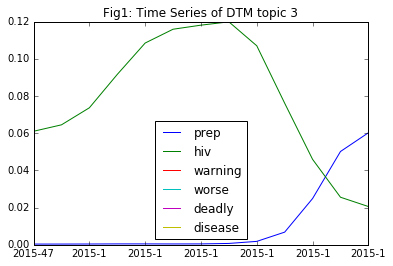

In [8]:
data = []
for t_index in range(len(model.time_slices)):
    words = model.show_topic(topicid=3, time=t_index, topn=1000)
        
    columns = ['prep', 'hiv', 'warning', 'worse', 'deadly', 'disease']
    row = []
    for col in columns:
        cell = [w[0] for w in words if w[1] == col]
        if not cell:
            cell = .000001
        else:
            cell = cell[0]
        row.append(cell)
    data.append(row)
    
df = pd.DataFrame(data, columns=columns, index=weeknums)
ax = df.plot(title='Fig1: Time Series of DTM topic 3')
fig = ax.get_figure()
fig.savefig('Fig1: Time Series of DTM topic 3.pdf', format='pdf')

# Table 2: top 10 words associated with topic ID 8 over time
Note how at time points 2 and 3 we get world AIDS day related words. At time points 7, 8 and 9 the antibiotic 'Zithromax' appears, then disappears. 'gay' also seems to come up during the later time points, which parallels the #egaylity in the Doc2Vec results. 'rt' is not entirely interesting, since it is the name of a news agency.

In [9]:
for t_index in range(len(model.time_slices)):
    print("--- time slice: ", t_index, "\n")
    print(pd.DataFrame(model.show_topic(topicid=8, time=t_index, topn=10), columns=['Probability', 'Word']))
    print()

--- time slice:  0 

   Probability       Word
0     0.110737    charlie
1     0.090555        hiv
2     0.069365      sheen
3     0.019287     sheens
4     0.018982    sheen's
5     0.011815       gave
6     0.011727      jenny
7     0.011420       told
8     0.011126  ex-angels
9     0.011123   mccarthy

--- time slice:  1 

   Probability        Word
0     0.096816     charlie
1     0.094974         hiv
2     0.067412       sheen
3     0.016785      sheens
4     0.016722     sheen's
5     0.012841        told
6     0.010922  girlfriend
7     0.010434    pornstar
8     0.009704        gave
9     0.008882      status

--- time slice:  2 

   Probability        Word
0     0.099475         hiv
1     0.081840     charlie
2     0.063198       sheen
3     0.013787     sheen's
4     0.013704      sheens
5     0.013516        told
6     0.010449  girlfriend
7     0.009610    pornstar
8     0.008811   diagnosis
9     0.007450       actor

--- time slice:  3 

   Probability        Word
0     

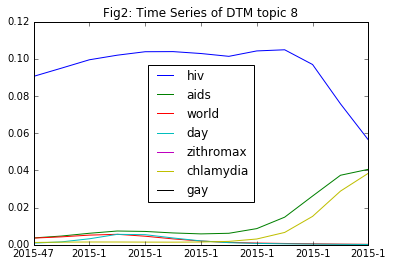

In [10]:
data = []
for t_index in range(len(model.time_slices)):
    words = model.show_topic(topicid=8, time=t_index, topn=1000)
        
    columns = ['hiv', 'aids', 'world', 'day', 'zithromax', 'chlamydia', 'gay']
    row = []
    for col in columns:
        cell = [w[0] for w in words if w[1] == col]
        if not cell:
            cell = .000001
        else:
            cell = cell[0]
        row.append(cell)
    data.append(row)


df = pd.DataFrame(data, columns=columns, index=weeknums)
ax = df.plot(title='Fig2: Time Series of DTM topic 8')
fig = ax.get_figure()
fig.savefig('Fig2: Time Series of DTM topic 8.pdf', format='pdf')